In [ ]:
#cell 1
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn modules for modeling, feature extraction, metrics, and hyperparameter tuning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    confusion_matrix, classification_report
)

# Statsmodels for optional advanced statistical analysis
import statsmodels.api as sm

# For audio feature extraction (librosa)
import librosa

# For image processing (OpenCV)
import cv2

# For ignoring warnings
import warnings
warnings.filterwarnings("ignore")

Found audio files:
/Users/ananyasingh/Desktop/newdata/audio/TESS Toronto emotional speech set data/YAF_disgust/YAF_date_disgust.wav
/Users/ananyasingh/Desktop/newdata/audio/TESS Toronto emotional speech set data/YAF_disgust/YAF_rag_disgust.wav
/Users/ananyasingh/Desktop/newdata/audio/TESS Toronto emotional speech set data/YAF_disgust/YAF_raise_disgust.wav
/Users/ananyasingh/Desktop/newdata/audio/TESS Toronto emotional speech set data/YAF_disgust/YAF_ditch_disgust.wav
/Users/ananyasingh/Desktop/newdata/audio/TESS Toronto emotional speech set data/YAF_disgust/YAF_door_disgust.wav
/Users/ananyasingh/Desktop/newdata/audio/TESS Toronto emotional speech set data/YAF_disgust/YAF_note_disgust.wav
/Users/ananyasingh/Desktop/newdata/audio/TESS Toronto emotional speech set data/YAF_disgust/YAF_pearl_disgust.wav
/Users/ananyasingh/Desktop/newdata/audio/TESS Toronto emotional speech set data/YAF_disgust/YAF_search_disgust.wav
/Users/ananyasingh/Desktop/newdata/audio/TESS Toronto emotional speech se

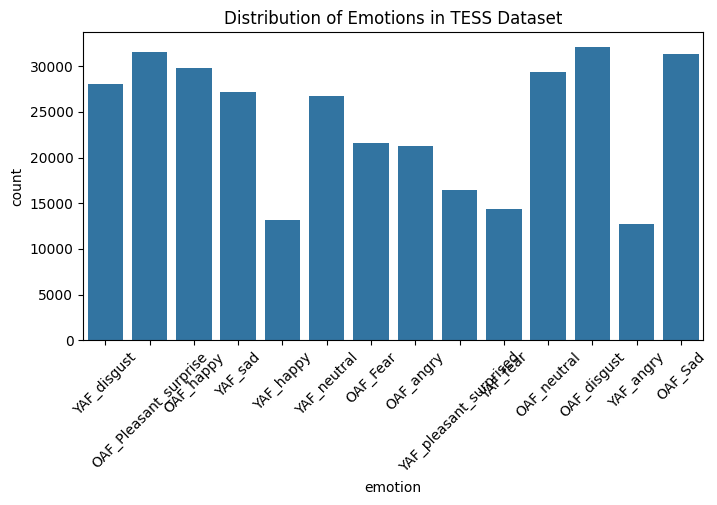

In [ ]:
#cell 2
import glob
import os
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Update the audio_path to point to your TESS data root
audio_path = "/Users/ananyasingh/Desktop/newdata/audio"

# Use recursive glob to capture .wav files in nested subfolders
audio_files = glob.glob(os.path.join(audio_path, "**/*.wav"), recursive=True)
print("Found audio files:")
for f in audio_files:
    print(f)

# Prepare lists to store feature vectors and labels
audio_features = []
audio_labels = []

def extract_mfcc(file_path, n_mfcc=128):
    """
    Load an audio file, extract MFCC features, 
    and return the mean of those features over time.
    """
    try:
        y, sr = librosa.load(file_path, sr=None)
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
        return np.mean(mfccs.T, axis=0)
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None


# Loop through each .wav file, extract MFCC, and label by the folder name
for file in audio_files:
    feats = extract_mfcc(file)
    if feats is not None:
        audio_features.append(feats)
        # Use the folder name as the label 
        # (the folder immediately containing the .wav file)
        label = os.path.basename(os.path.dirname(file))
        audio_labels.append(label)

# Build a DataFrame of audio features
audio_df = pd.DataFrame(audio_features)
audio_df['emotion'] = audio_labels

print("\nAudio DataFrame shape:", audio_df.shape)
print("Columns:", audio_df.columns.tolist())
print(audio_df.head())

# Basic distribution of emotion labels
plt.figure(figsize=(8,4))
sns.countplot(x='emotion', data=audio_df)
plt.title("Distribution of Emotions in TESS Dataset")
plt.xticks(rotation=45)
plt.show()

Found 5600 audio files.

Audio DataFrame shape: (5600, 129)
Columns: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 'emotion']
            0          1          2          3         4          5  \
0 -434.324219  55.251427   1.085584  33.359203 -0.081254  -9.487000   
1 -389.423798  79.242538  -7.156283  11.294464 -2.657189 -13.059341   
2 -413.006409  60.603519  10.533782  14.332574  0.240233 -10.573189   
3 -436.991699  50.012699  -2.480485  30.096598 -4.718028  -2.506720   
4 -414.527679  80.787315  15.02898

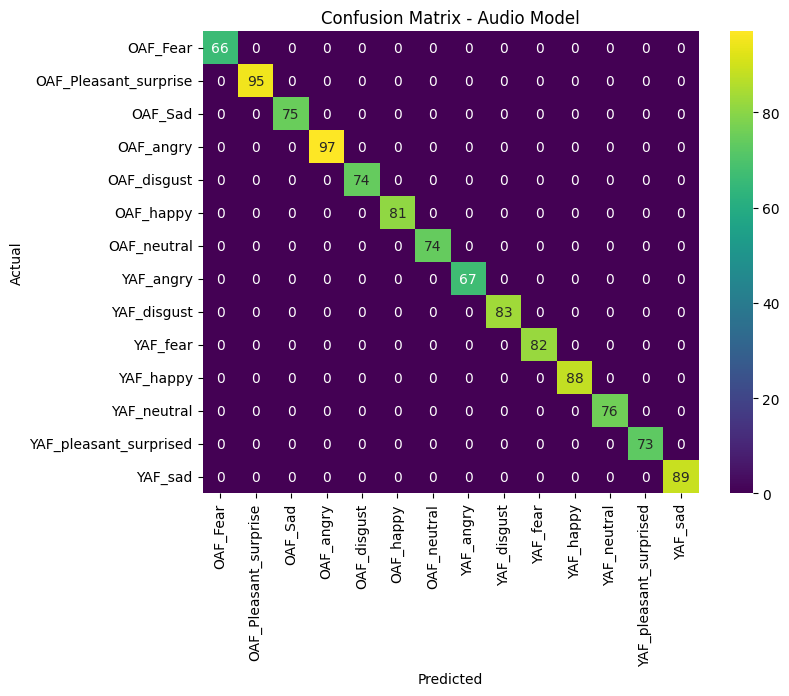


✅ Model, Label Encoder, and Scaler Saved Successfully!


In [ ]:
#cell 3
import glob
import os
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, confusion_matrix

# =========================== DATA LOADING ===========================
# Update the path to your TESS dataset
audio_path = "/Users/ananyasingh/Desktop/newdata/audio"

# Find all .wav files (recursive search in subdirectories)
audio_files = glob.glob(os.path.join(audio_path, "**/*.wav"), recursive=True)

print(f"Found {len(audio_files)} audio files.")

# Prepare lists to store feature vectors and labels
audio_features = []
audio_labels = []

def extract_mfcc(file_path, n_mfcc=128):
    """
    Load an audio file, extract MFCC features, 
    and return the mean of those features over time.
    """
    try:
        y, sr = librosa.load(file_path, sr=None)
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
        return np.mean(mfccs.T, axis=0)  # Compute mean along time-axis
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

# Extract features and labels
for file in audio_files:
    feats = extract_mfcc(file)
    if feats is not None:
        audio_features.append(feats)
        label = os.path.basename(os.path.dirname(file))  # Folder name as label
        audio_labels.append(label)

# Create a DataFrame from extracted features
audio_df = pd.DataFrame(audio_features)
audio_df['emotion'] = audio_labels

print("\nAudio DataFrame shape:", audio_df.shape)
print("Columns:", audio_df.columns.tolist())
print(audio_df.head())

# =========================== DATA PREPROCESSING ===========================
# Encode emotion labels
audio_le = LabelEncoder()
audio_df['emotion_enc'] = audio_le.fit_transform(audio_df['emotion'])

# Features (MFCCs) and target labels
X_audio = audio_df.drop(['emotion', 'emotion_enc'], axis=1).values  
y_audio = audio_df['emotion_enc'].values  

# 🔹 **Apply Feature Scaling**
scaler = StandardScaler()
X_audio_scaled = scaler.fit_transform(X_audio)  # Fit and transform training features

# Train-test split (80% training, 20% testing)
X_train_audio, X_test_audio, y_train_audio, y_test_audio = train_test_split(
    X_audio_scaled, y_audio, test_size=0.2, random_state=42
)

# =========================== MODEL TRAINING ===========================
# Train a Random Forest classifier
audio_clf = RandomForestClassifier(n_estimators=100, random_state=42)
audio_clf.fit(X_train_audio, y_train_audio)

# Predictions
y_pred_audio = audio_clf.predict(X_test_audio)

# =========================== EVALUATION ===========================
acc_audio = accuracy_score(y_test_audio, y_pred_audio)
prec_audio = precision_score(y_test_audio, y_pred_audio, average='weighted')
rec_audio = recall_score(y_test_audio, y_pred_audio, average='weighted')

print("\n🎯 Audio Model Evaluation:")
print("✅ Accuracy:", acc_audio)
print("✅ Precision (weighted):", prec_audio)
print("✅ Recall (weighted):", rec_audio)

# Classification Report
print("\n📊 Classification Report:\n", 
      classification_report(y_test_audio, y_pred_audio, target_names=audio_le.classes_))

# Confusion Matrix
cm_audio = confusion_matrix(y_test_audio, y_pred_audio)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_audio, annot=True, fmt='d', cmap='viridis',
            xticklabels=audio_le.classes_,
            yticklabels=audio_le.classes_)
plt.title("Confusion Matrix - Audio Model")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# =========================== SAVE TRAINED MODEL ===========================
# Save the trained model and scaler
joblib.dump(audio_clf, 'random_forest_audio.pkl')
joblib.dump(audio_le, 'audio_label_encoder.pkl')
joblib.dump(scaler, 'scaler.pkl')  # ✅ Save the scaler

print("\n✅ Model, Label Encoder, and Scaler Saved Successfully!")




In [11]:
import joblib

# Save the trained model
joblib.dump(audio_clf, 'random_forest_audio.pkl')

# Save the label encoder (so we can decode predictions later)
joblib.dump(audio_le, 'audio_label_encoder.pkl')

import joblib

# Save the face emotion classifier
joblib.dump(img_clf, "random_forest_face.pkl")

# Save the face label encoder
joblib.dump(img_le, "face_label_encoder.pkl")



['face_label_encoder.pkl']

Found image files:
/Users/ananyasingh/Desktop/newdata/emotions/test/happy/PrivateTest_45699463.jpg
/Users/ananyasingh/Desktop/newdata/emotions/test/happy/PrivateTest_61855708.jpg
/Users/ananyasingh/Desktop/newdata/emotions/test/happy/PublicTest_53681781.jpg
/Users/ananyasingh/Desktop/newdata/emotions/test/happy/PrivateTest_52109800.jpg
/Users/ananyasingh/Desktop/newdata/emotions/test/happy/PublicTest_41104919.jpg
/Users/ananyasingh/Desktop/newdata/emotions/test/happy/PrivateTest_16487993.jpg
/Users/ananyasingh/Desktop/newdata/emotions/test/happy/PublicTest_62445662.jpg
/Users/ananyasingh/Desktop/newdata/emotions/test/happy/PublicTest_10283102.jpg
/Users/ananyasingh/Desktop/newdata/emotions/test/happy/PublicTest_16609356.jpg
/Users/ananyasingh/Desktop/newdata/emotions/test/happy/PrivateTest_32138585.jpg
/Users/ananyasingh/Desktop/newdata/emotions/test/happy/PrivateTest_57229385.jpg
/Users/ananyasingh/Desktop/newdata/emotions/test/happy/PrivateTest_22108748.jpg
/Users/ananyasingh/Desktop

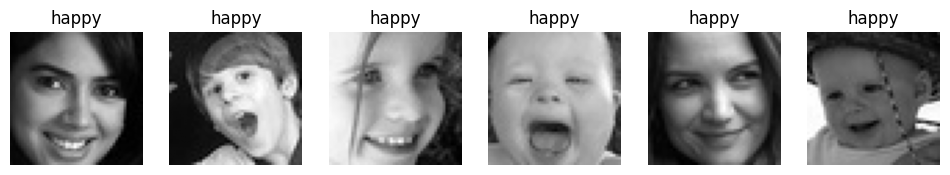

In [6]:
# Cell 4: Load and process FER2013 (or other emotion) images
import glob
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

image_path = "/Users/ananyasingh/Desktop/newdata/emotions"

# Use recursive glob to capture .jpg files in nested subfolders
image_files = glob.glob(os.path.join(image_path, "**/*.jpg"), recursive=True)
print("Found image files:")
for f in image_files:
    print(f)

img_data = []
img_labels = []
target_size = (48, 48)  # typical dimension for FER2013

for file in image_files:
    try:
        img = cv2.imread(file)
        if img is None:
            continue
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img_resized = cv2.resize(img_gray, target_size)
        img_data.append(img_resized.flatten())
        # Use the folder name as the label
        label = os.path.basename(os.path.dirname(file))
        img_labels.append(label)
    except Exception as e:
        print(f"Error processing {file}: {e}")

X_img = np.array(img_data)
y_img = np.array(img_labels)

print("Image dataset shape:", X_img.shape)
print("Unique labels in image dataset:", np.unique(y_img))

# Visualize a few images
plt.figure(figsize=(12,4))
for i in range(min(6, len(X_img))):
    plt.subplot(1,6,i+1)
    plt.imshow(X_img[i].reshape(target_size), cmap='gray')
    plt.title(y_img[i])
    plt.axis('off')
plt.show()

Model saved as random_forest_emotion.pkl

Image Model Evaluation:
Accuracy: 0.4668431317915854
Precision (weighted): 0.4862083821461838
Recall (weighted): 0.4668431317915854

Classification Report:
               precision    recall  f1-score   support

       angry       0.53      0.18      0.27       993
     disgust       0.96      0.23      0.37        99
        fear       0.50      0.28      0.36      1017
       happy       0.45      0.80      0.57      1796
     neutral       0.45      0.39      0.42      1273
         sad       0.36      0.37      0.37      1191
    surprise       0.69      0.61      0.65       809

    accuracy                           0.47      7178
   macro avg       0.56      0.41      0.43      7178
weighted avg       0.49      0.47      0.44      7178



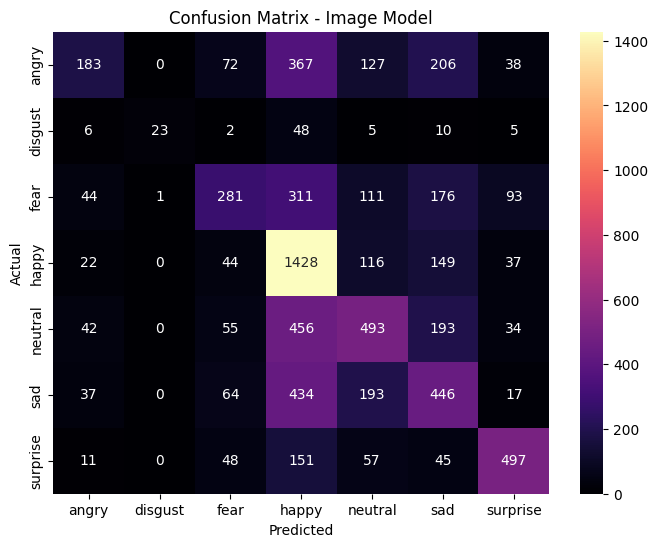

Model successfully loaded!


In [ ]:
#cell 5
import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Encode emotion labels
img_le = LabelEncoder()
y_img_enc = img_le.fit_transform(y_img)

# Train-test split
X_train_img, X_test_img, y_train_img, y_test_img = train_test_split(
    X_img, y_img_enc, test_size=0.2, random_state=42
)

# Normalize pixel values
X_train_img = X_train_img / 255.0
X_test_img = X_test_img / 255.0

# Define Random Forest Classifier
img_clf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)  # Use all CPU cores for speed
img_clf.fit(X_train_img, y_train_img)

# Save trained model
model_filename = "random_forest_emotion.pkl"
joblib.dump(img_clf, model_filename)
print(f"Model saved as {model_filename}")

# Predictions
y_pred_img = img_clf.predict(X_test_img)

# Evaluation Metrics
acc_img = accuracy_score(y_test_img, y_pred_img)
prec_img = precision_score(y_test_img, y_pred_img, average='weighted')
rec_img = recall_score(y_test_img, y_pred_img, average='weighted')

print("\nImage Model Evaluation:")
print("Accuracy:", acc_img)
print("Precision (weighted):", prec_img)
print("Recall (weighted):", rec_img)

print("\nClassification Report:\n",
      classification_report(y_test_img, y_pred_img, target_names=img_le.classes_))

# Confusion Matrix
cm_img = confusion_matrix(y_test_img, y_pred_img)
plt.figure(figsize=(8,6))
sns.heatmap(cm_img, annot=True, fmt='d', cmap='magma',
            xticklabels=img_le.classes_,
            yticklabels=img_le.classes_)
plt.title("Confusion Matrix - Image Model")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Load the model (for future use)
if os.path.exists(model_filename):
    loaded_model = joblib.load(model_filename)
    print("Model successfully loaded!")


In [ ]:
#cell 6
import cv2
import numpy as np
import joblib
import librosa
import pyaudio
import wave
import os
import time

# Load trained models and scaler
face_model = joblib.load("random_forest_emotion.pkl")
audio_model = joblib.load("random_forest_audio.pkl")  
face_le = joblib.load("face_label_encoder.pkl")  
audio_le = joblib.load("audio_label_encoder.pkl")
scaler = joblib.load("scaler.pkl")  # Load pre-trained scaler

# Parameters
target_size = (48, 48)
audio_duration = 2

# Face detector
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

def predict_face_emotion(frame):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    if len(faces) == 0:
        return None

    x, y, w, h = faces[0]
    face_crop = cv2.resize(gray[y:y+h, x:x+w], target_size) / 255.0
    face_flat = face_crop.flatten().reshape(1, -1)

    return face_le.inverse_transform(face_model.predict(face_flat))[0]

def predict_audio_emotion():
    CHUNK = 1024
    FORMAT = pyaudio.paInt16
    CHANNELS = 1
    RATE = 44100
    WAVE_OUTPUT_FILENAME = "temp_audio.wav"

    print("\nPlease speak now...")
    time.sleep(2)
    print("Recording...")

    audio = pyaudio.PyAudio()
    stream = audio.open(format=FORMAT, channels=CHANNELS, rate=RATE, input=True, frames_per_buffer=CHUNK)

    frames = [stream.read(CHUNK) for _ in range(int(RATE / CHUNK * audio_duration))]

    print("Recording finished.")
    stream.stop_stream()
    stream.close()
    audio.terminate()

    wf = wave.open(WAVE_OUTPUT_FILENAME, 'wb')
    wf.setnchannels(CHANNELS)
    wf.setsampwidth(audio.get_sample_size(FORMAT))
    wf.setframerate(RATE)
    wf.writeframes(b''.join(frames))
    wf.close()

    # Extract MFCC features
    y, sr = librosa.load(WAVE_OUTPUT_FILENAME, sr=RATE)
    y = librosa.util.normalize(y)  # Normalize audio
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=128)
    mfccs_mean = np.mean(mfccs, axis=1).reshape(1, -1)

    os.remove(WAVE_OUTPUT_FILENAME)

    # Use pre-trained scaler
    mfccs_mean = scaler.transform(mfccs_mean)

    # Predict emotion
    audio_pred = audio_model.predict(mfccs_mean)[0]
    return audio_le.inverse_transform([audio_pred])[0]

# Start webcam
cap = cv2.VideoCapture(0)

if not cap.isOpened():
    print("Error: Could not open webcam.")
    exit()

print("\nStarting Face Emotion Detection in 2 seconds...")
time.sleep(2)

ret, frame = cap.read()
if not ret:
    print("Error: Could not capture frame.")
    cap.release()
    exit()

face_emotion = predict_face_emotion(frame)

if face_emotion:
    print(f"Face emotion detected: {face_emotion}")
else:
    print("No face detected.")

cap.release()

print("\nStarting Audio Emotion Detection in 2 seconds...")
time.sleep(2)

audio_emotion = predict_audio_emotion()
print(f"Audio emotion detected: {audio_emotion}")

print(f"\nFinal Predicted Emotion -> Face: {face_emotion}, Audio: {audio_emotion}")
print("Process completed.")



Starting Face Emotion Detection in 2 seconds...
Face emotion detected: neutral

Starting Audio Emotion Detection in 2 seconds...

Please speak now...
Recording...
Recording finished.
Audio emotion detected: YAF_disgust

Final Predicted Emotion -> Face: neutral, Audio: YAF_disgust
Process completed.
